### Using mlcolvar with dual-cutoff graph network network models

Applying GNN CVs to complex process, such as protein folding or ligand binding, often presents specific challenges due to the reliance of geometric GNNs on the adjacency matrix $\mathbf{A}$. The matrix is typically defined such that $\mathbf{A}_{ij}=1$ if the distance between atoms $i$ and $j$ satisfies $||e_{ij}|| < r_c$, and $\mathbf{A}_{ij} = 0$ otherwise, where $r_c$ denotes a predefined cutoff radius. During enhanced sampling, the system may evolve in such a way that key structural components—such as unfolding protein segments or dissociating ligands—become spatially distant, with their pairwise distances exceeding the cutoff (i.e., $||e_{ij}|| > r_c$). This results in a loss of connectivity between functionally relevant but distant nodes, preventing the propagation of long-range information. As a consequence, the expressiveness of the learned CVs is degraded, potentially leading to the failure of the enhanced sampling process. Furthermore, GNNs are computationally more expensive than feedforward neural networks, as the cutoff radius cannot be arbitrarily increased without incurring substantial growth in graph size and computational cost.

In [3]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh TUTORIAL', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

In [4]:
from mlcolvar.data import DictModule
import mlcolvar.graph as mg

# loading arguments 
# same as to laod_dataframe
load_args = [{'start' : 0, 'stop' : 5000, 'stride' : 5},
               {'start' : 0, 'stop' : 5000, 'stride' : 5}]

dataset = mg.utils.io.create_dataset_from_trajectories(
    trajectories=[
        'data/nacl/traj_r.xtc',
        'data/nacl/traj_p.xtc'
        ],
    top=['data/nacl/nacl.pdb', 'data/nacl/nacl.pdb'],
    cutoff=4.0,  # Angstrom
    cutoff_l=8.0,
    buffer=1.0,
    create_labels=True,
    system_selection='type Na or type Cl',
    environment_selection='type O',
    subsystem_selection= 'type Na or type Cl',
    show_progress=True,
    load_args=load_args,
)

print('Dataset info:\n', dataset, end="\n\n")

# load dataset into a DictModule
datamodule = mg.data.GraphDataModule(dataset)
print('Datamodule info:\n', datamodule)


 Making graphs ━━━━━━━━━━━━━━━━━━━━━━━━━ 1/2000 Est. 15:49.7
 Making graphs ━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2000 Est. 08:2.1
 Making graphs ━━━━━━━━━━━━━━━━━━━━━━━━━ 3/2000 Est. 05:25.5
 Making graphs ━━━━━━━━━━━━━━━━━━━━━━━━━ 4/2000 Est. 04:7.4
 Making graphs ━━━━━━━━━━━━━━━━━━━━━━━━━ 5/2000 Est. 03:20.3
 Making graphs ━━━━━━━━━━━━━━━━━━━━━━━━━ 6/2000 Est. 02:48.9
 Making graphs ━━━━━━━━━━━━━━━━━━━━━━━━━ 7/2000 Est. 02:26.5
 Making graphs ━━━━━━━━━━━━━━━━━━━━━━━━━ 8/2000 Est. 02:9.7
 Making graphs ━━━━━━━━━━━━━━━━━━━━━━━━━ 9/2000 Est. 01:56.5
 Making graphs ━━━━━━━━━━━━━━━━━━━━━━━━━ 10/2000 Est. 01:46.1
 Making graphs ━━━━━━━━━━━━━━━━━━━━━━━━━ 11/2000 Est. 01:37.5
 Making graphs ━━━━━━━━━━━━━━━━━━━━━━━━━ 12/2000 Est. 01:30.4
 Making graphs ━━━━━━━━━━━━━━━━━━━━━━━━━ 13/2000 Est. 01:24.3
 Making graphs ━━━━━━━━━━━━━━━━━━━━━━━━━ 14/2000 Est. 01:19.1
 Making graphs ━━━━━━━━━━━━━━━━━━━━━━━━━ 15/2000 Est. 01:14.4
 Making graphs ━━━━━━━━━━━━━━━━━━━━━━━━━ 16/2000 E

In [5]:
# define model

model = mg.cvs.GraphDeepTDA(
    n_cvs=1,
    cutoff=dataset.cutoff,
    cutoff_l=dataset.cutoff_l,
    atomic_numbers=dataset.atomic_numbers,
    target_centers=[-7, 7],
    target_sigmas=[0.2, 0.2],
    model_name='SchNetModel',
    model_options={
        'n_bases': 14,
        'n_layers': 3,
        'n_filters': 28,
        'n_hidden_channels': 24,
    },
)


In [6]:
from lightning import Trainer
from mlcolvar.utils.trainer import MetricsCallback

# Define trainer and callback
metrics = MetricsCallback()
trainer = Trainer(
    callbacks=[metrics],
    logger=False,
    enable_checkpointing=False,
    max_epochs=400,
    enable_model_summary=False
)

# Train the model
trainer.fit(model, datamodule)
model = model.eval()

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/home/zhukai/anaconda3/envs/mlcolvar-gnn/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/zhukai/anaconda3/envs/mlcolvar-gnn/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zhukai/anaconda3/envs/mlcolvar-gnn/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/zhukai/anaconda3/envs/mlcolvar-gnn/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=191` in the `DataLoader` to improve performance.


/home/zhukai/anaconda3/envs/mlcolvar-gnn/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/zhukai/anaconda3/envs/mlcolvar-gnn/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=191` in the `DataLoader` to improve performance.


Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


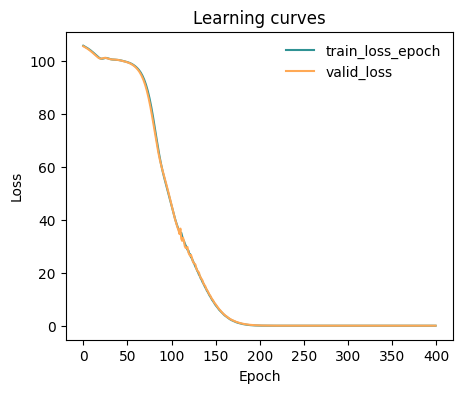

In [7]:
from mlcolvar.utils.plot import plot_metrics

# plot metrics
ax = plot_metrics(metrics.metrics,
                  keys=['train_loss_epoch', 'valid_loss'],
                  colors=['fessa1','fessa5'],
                  yscale='linear',)

Text(0.5, 1.0, 'Output Distribution')

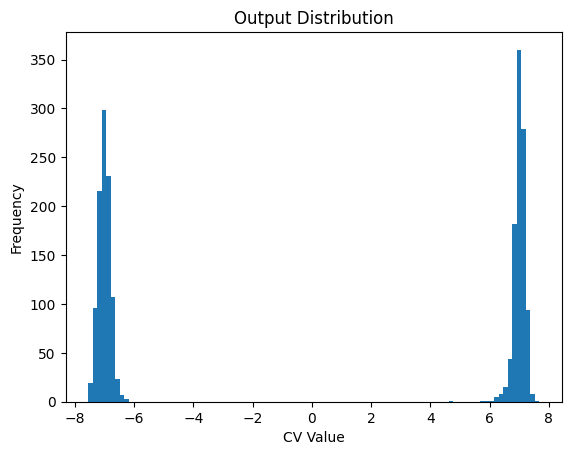

In [8]:
from matplotlib import pyplot as plt
import torch

datamodule = mg.data.GraphDataModule(dataset, lengths=(1,))
datamodule.setup()

# Plot output distribution histogram
with torch.no_grad():
    data = next(iter(datamodule.train_dataloader()))
    out = model(data)

out_values = out.detach().squeeze()

plt.hist(out_values, bins=100)
plt.xlabel('CV Value')
plt.ylabel('Frequency')
plt.title('Output Distribution')

In [ ]:
model.to_torchscript('model_twocut.ptc')